In [1]:
!pip install "deeplake<4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.9/639.9 kB 11.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 83.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
  Created wheel for deeplake: filename=deeplake-3.9.43-py3-none-any.whl size=768350 sha256=9f3ea028805065598b5d521255e4a54b53d9af49e6cb8633c34fa83d26a314b8
  Stored in directory: /root/.cache/pip/wheels/4d/93/e1/524ad6f1224791941740dac97bb6e1696e89efc990ff56c24c
Successfully built deeplake
  Attempting uninstall: aiofiles
    Found existing installation: aiofiles 22.1.0
    Uninstalling aiofiles-22.1.0:
      Successfully uninstalled aiofiles-22.1.0
ERROR: pip's dependency resolver does not currently take into account all 

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import deeplake
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle


full_ds = deeplake.load("hub://activeloop/animal10n-train")

full_images = full_ds["images"].numpy()
full_labels = full_ds["labels"].numpy()

indices = np.arange(len(full_images))
np.random.shuffle(indices)

split_ratio = 0.8
split_idx = int(len(indices) * split_ratio)

train_indices, val_indices = indices[:split_idx], indices[split_idx:]
train_images, train_labels = full_images[train_indices], full_labels[train_indices]
val_images, val_labels = full_images[val_indices], full_labels[val_indices]

RESCALE_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 10
LR = 0.02

def get_hyperparameters():
    return {
        "lr": LR,
        "batch_size": BATCH_SIZE,
        "num_epochs": EPOCHS,
    }

params = get_hyperparameters()

class AnimalDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = Image.fromarray(image.astype('uint8'), 'RGB')
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))

        if self.transform:
            image = self.transform(image)

        label_id = self.label_encoder.transform([label])[0]
        return image, label_id

transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = AnimalDataset(train_images, train_labels, transform=transform)
val_dataset = AnimalDataset(val_images, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=8)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(in_features=512, out_features=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc

def train(model, train_loader, val_loader, epochs, batch_size):
    optimizer = optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    history = []

    log_template = "Epoch {ep:03d} | Train Loss: {t_loss:.4f} | Train Acc: {t_acc:.4f} | Val Loss: {v_loss:.4f} | Val Acc: {v_acc:.4f}"
    
    with tqdm(desc="Training Progress", total=epochs) as pbar:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc, v_loss=val_loss, v_acc=val_acc))
    
    return history

history = train(model, train_loader, val_loader, params["num_epochs"], params["batch_size"])

torch.save(model.state_dict(), "animal10n_resnet18.pth")

-

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/animal10n-train



/

hub://activeloop/animal10n-train loaded successfully.



 Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]
Training Progress:  10%|█         | 1/10 [02:17<20:33, 137.08s/it]

Epoch 001 | Train Loss: 2.1436 | Train Acc: 0.2615 | Val Loss: 2.0778 | Val Acc: 0.2724


Training Progress:  20%|██        | 2/10 [04:45<19:11, 143.96s/it]

Epoch 002 | Train Loss: 1.7270 | Train Acc: 0.3765 | Val Loss: 1.6458 | Val Acc: 0.3922


Training Progress:  30%|███       | 3/10 [07:13<16:58, 145.57s/it]

Epoch 003 | Train Loss: 1.5529 | Train Acc: 0.4392 | Val Loss: 1.5853 | Val Acc: 0.4272


Training Progress:  40%|████      | 4/10 [09:40<14:37, 146.32s/it]

Epoch 004 | Train Loss: 1.4786 | Train Acc: 0.4663 | Val Loss: 1.5618 | Val Acc: 0.4238


Training Progress:  50%|█████     | 5/10 [12:09<12:15, 147.01s/it]

Epoch 005 | Train Loss: 1.4231 | Train Acc: 0.4845 | Val Loss: 1.4868 | Val Acc: 0.4653


Training Progress:  60%|██████    | 6/10 [14:36<09:48, 147.03s/it]

Epoch 006 | Train Loss: 1.3888 | Train Acc: 0.5027 | Val Loss: 1.6788 | Val Acc: 0.4142


Training Progress:  70%|███████   | 7/10 [17:05<07:23, 147.74s/it]

Epoch 007 | Train Loss: 1.3506 | Train Acc: 0.5147 | Val Loss: 1.4348 | Val Acc: 0.4815


Training Progress:  80%|████████  | 8/10 [19:33<04:55, 147.85s/it]

Epoch 008 | Train Loss: 1.3208 | Train Acc: 0.5277 | Val Loss: 1.4023 | Val Acc: 0.5027


Training Progress:  90%|█████████ | 9/10 [21:59<02:27, 147.37s/it]

Epoch 009 | Train Loss: 1.2871 | Train Acc: 0.5372 | Val Loss: 1.3706 | Val Acc: 0.5126


Training Progress: 100%|██████████| 10/10 [24:26<00:00, 146.63s/it]

Epoch 010 | Train Loss: 1.2525 | Train Acc: 0.5529 | Val Loss: 1.5748 | Val Acc: 0.4679


In [7]:
loss, acc, val_loss, val_acc = zip(*history)

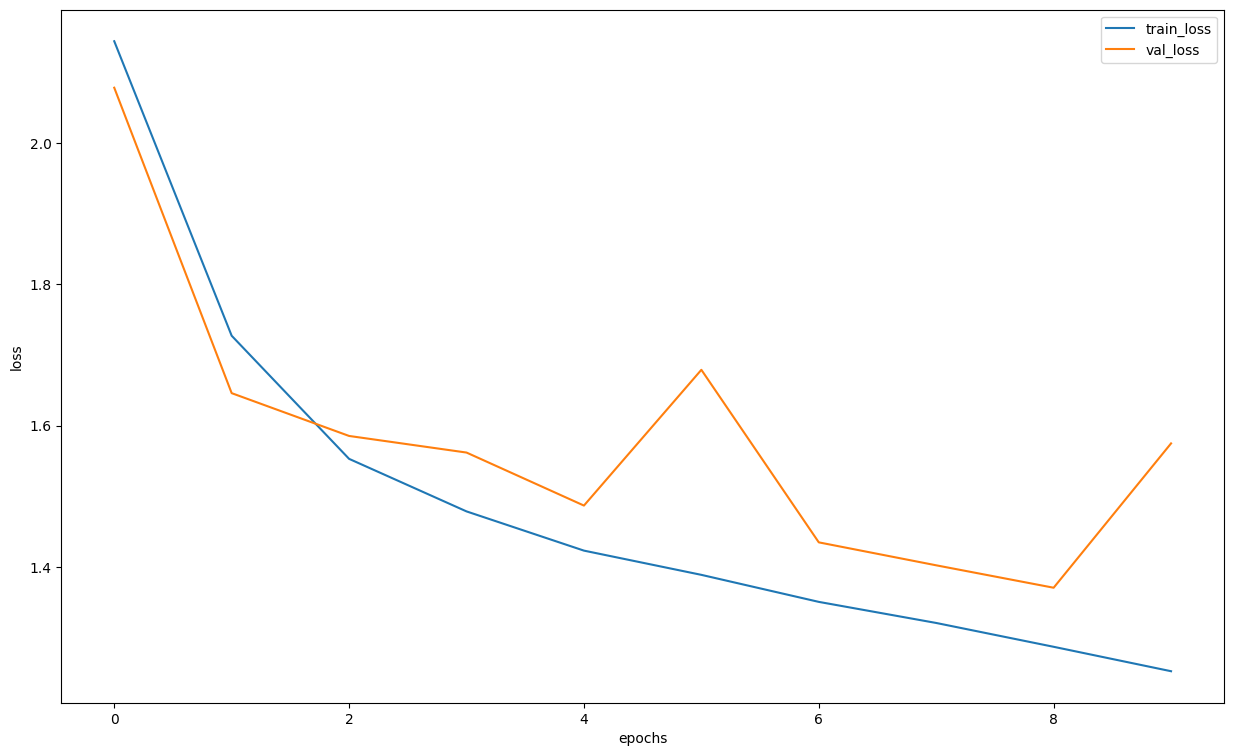

In [8]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()